In [0]:
dbutils.fs.ls("/FileStore/tables/")

Out[2]: [FileInfo(path='dbfs:/FileStore/tables/accounts/', name='accounts/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts-1.zip', name='accounts-1.zip', size=5297592, modificationTime=1645026603000),
 FileInfo(path='dbfs:/FileStore/tables/accounts-2.zip', name='accounts-2.zip', size=5297592, modificationTime=1647878306000),
 FileInfo(path='dbfs:/FileStore/tables/accounts-3.zip', name='accounts-3.zip', size=5297592, modificationTime=1647940218000),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1645026541000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2019_csv.gz', name='clinicaltrial_2019_csv.gz', size=10060669, modificationTime=1650985353000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020_csv.gz', name='clinicaltrial_2020_csv.gz', size=10981608, modificationTime=1650985356000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021/', name='clinicaltrial_2021/', size=0,

In [0]:
dbutils.fs.cp("dbfs:/FileStore/tables/clinicaltrial_2021_csv.gz","file:/tmp")

Out[3]: True

In [0]:
%sh
gunzip /tmp/clinicaltrial_2021_csv.gz 

In [0]:
%sh
ls /tmp/

Rserv
RtmpHQLYGU
chauffeur-daemon-params
chauffeur-daemon.pid
chauffeur-env.sh
clinicaltrial_2021_csv
custom-spark.conf
driver-daemon-params
driver-daemon.pid
driver-env.sh
hsperfdata_root
ipykernel-connection-ReplId-466b6-785e5-eac5b-1.json
ipykernel-connection-ReplId-83c01-6ae21-ecafc.json
ipykernel-connection-ReplId-ba7fe-cf96e-2bd00.json
systemd-private-2b5aa77e486444f390e20aaef49dd02a-apache2.service-n0CLti
systemd-private-2b5aa77e486444f390e20aaef49dd02a-ntp.service-KuEtki
systemd-private-2b5aa77e486444f390e20aaef49dd02a-systemd-logind.service-Bf2Jlf
systemd-private-2b5aa77e486444f390e20aaef49dd02a-systemd-resolved.service-609jwi
tmp.adwUAxRjWM


In [0]:
dbutils.fs.mkdirs("dbfs:/FileStore/tables/clinicaltrial_2021")

Out[6]: True

In [0]:
dbutils.fs.mv("file:/tmp/clinicaltrial_2021_csv","dbfs:/FileStore/tables/clinicaltrial_2021.csv")

Out[7]: True

In [0]:
dbutils.fs.ls("/FileStore/tables")

Out[8]: [FileInfo(path='dbfs:/FileStore/tables/accounts/', name='accounts/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts-1.zip', name='accounts-1.zip', size=5297592, modificationTime=1645026603000),
 FileInfo(path='dbfs:/FileStore/tables/accounts-2.zip', name='accounts-2.zip', size=5297592, modificationTime=1647878306000),
 FileInfo(path='dbfs:/FileStore/tables/accounts-3.zip', name='accounts-3.zip', size=5297592, modificationTime=1647940218000),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1645026541000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2019_csv.gz', name='clinicaltrial_2019_csv.gz', size=10060669, modificationTime=1650985353000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020_csv.gz', name='clinicaltrial_2020_csv.gz', size=10981608, modificationTime=1650985356000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021/', name='clinicaltrial_2021/', size=0,

In [0]:
import pyspark.sql.functions as A

clinicaltrial_2021 = spark.read.options(delimiter = "|", header = True, inferSchema = True).csv("/FileStore/tables/clinicaltrial_2021.csv")

pharma = spark.read.options(escape = "\"", header = True, inferSchema = True).csv("/FileStore/tables/pharma.csv")

mesh = spark.read.options(escape = "\"", header = True, inferSchema = True).csv("/FileStore/tables/mesh.csv").withColumn("code", A.split(A.col("tree"), "\.")[0]).withColumn("term", A.trim("term"))

In [0]:
#Q1 = "The number of studies in the dataset. You must ensure that you explicitly check distinct studies."

clinicaltrial_2021.select('Id').distinct().count()

Out[10]: 387261

In [0]:
#Q2 = "You should list all the types (as contained in the Type column) of studies in the dataset along with the frequencies of each type. These should be ordered from most frequent to least frequent."

clinicaltrial_2021.dropna(subset = "Type").groupBy("Type").count().orderBy("count", ascending = False).show()

+--------------------+------+
|                Type| count|
+--------------------+------+
|      Interventional|301472|
|       Observational| 77540|
|Observational [Pa...|  8180|
|     Expanded Access|    69|
+--------------------+------+



In [0]:
#Q3 = "The top 5 conditions (from Conditions) with their frequencies." 

conds = clinicaltrial_2021.select('Conditions').dropna(subset = "Conditions").withColumn("temp cond", A.explode(A.split(A.col("Conditions"), ","))).groupBy(A.trim("temp cond").alias("Conditions")).count().orderBy("count", ascending = False)
conds.show(5)

+-----------------+-----+
|       Conditions|count|
+-----------------+-----+
|        Carcinoma|13389|
|Diabetes Mellitus|11080|
|        Neoplasms| 9371|
| Breast Neoplasms| 8640|
|         Syndrome| 8032|
+-----------------+-----+
only showing top 5 rows



In [0]:
#Q4 = "Each condition can be mapped to one or more hierarchy codes. The client wishes to know the 5 most frequent roots (i.e. the sequence of letters and numbers before the first full stop) after this is done." 

conds.join(mesh, A.col("Conditions") == A.col("term"), "left").groupBy("code").sum("count").orderBy("sum(count)", ascending = False).show(5)

+----+----------+
|code|sum(count)|
+----+----------+
| C04|    143994|
| C23|    136079|
| C01|    106674|
| C14|     94523|
| C10|     92310|
+----+----------+
only showing top 5 rows



In [0]:
conds.join(mesh, A.col("Conditions") == A.col("term"), "left").groupBy("code").sum("count").orderBy("sum(count)", ascending = False).show(10)

+----+----------+
|code|sum(count)|
+----+----------+
| C04|    143994|
| C23|    136079|
| C01|    106674|
| C14|     94523|
| C10|     92310|
| C06|     85646|
| C08|     70720|
| C13|     42599|
| C18|     41276|
| C12|     40161|
+----+----------+
only showing top 10 rows



In [0]:
#Q5 = "Find the 10 most common sponsors that are not pharmaceutical companies, along with the number of clinical trials they have sponsored. Hint: For a basic implementation, you can assume that the Parent Company column contains all possible pharmaceutical companies." 

pharma1 = [row['Parent_Company'] for row in pharma.select("Parent_Company").distinct().collect()]
clinicaltrial_2021.filter(~A.col('Sponsor').isin(pharma1)).groupBy(A.col("Sponsor")).count().orderBy("count", ascending = False).show(10)

+--------------------+-----+
|             Sponsor|count|
+--------------------+-----+
|National Cancer I...| 3218|
|M.D. Anderson Can...| 2414|
|Assistance Publiq...| 2369|
|         Mayo Clinic| 2300|
|Merck Sharp & Doh...| 2243|
|   Assiut University| 2154|
|Novartis Pharmace...| 2088|
|Massachusetts Gen...| 1971|
|    Cairo University| 1928|
|   Hoffmann-La Roche| 1828|
+--------------------+-----+
only showing top 10 rows



In [0]:
#Q6 = "Plot number of completed studies each month in a given year – for the submission dataset, the year is 2021. You need to include your visualization as well as a table of all the values you have plotted for each month" 

clinicaltrial_2021.filter((A.col("Status") == 'Completed') & (A.split(A.col("Completion"), " ")[1] == '2021')).groupBy(A.col("Completion")).count().orderBy("count", ascending = False).show()

+----------+-----+
|Completion|count|
+----------+-----+
|  Mar 2021| 1227|
|  Jan 2021| 1131|
|  Jun 2021| 1094|
|  May 2021|  984|
|  Apr 2021|  967|
|  Feb 2021|  934|
|  Jul 2021|  819|
|  Aug 2021|  700|
|  Sep 2021|  528|
|  Oct 2021|  187|
+----------+-----+



In [0]:
#To visualize using Pie Chart in Matplotlib 

import pandas as pd

In [0]:
df = pd.DataFrame({'count': [1227, 1131, 1094, 984, 967, 934, 819, 700, 528, 187]}, 
                  index=['Mar 2021', 'Jan 2021', 'Jun 2021', 'May 2021', 'Apr 2021', 'Feb 2021', 'Jul 2021', 'Aug 2021', 'Sep 2021', 'Oct 2021'])

In [0]:
df

,count
Mar 2021,1227
Jan 2021,1131
Jun 2021,1094
May 2021,984
Apr 2021,967
Feb 2021,934
Jul 2021,819
Aug 2021,700
Sep 2021,528
Oct 2021,187


Out[36]: <AxesSubplot:ylabel='count'>

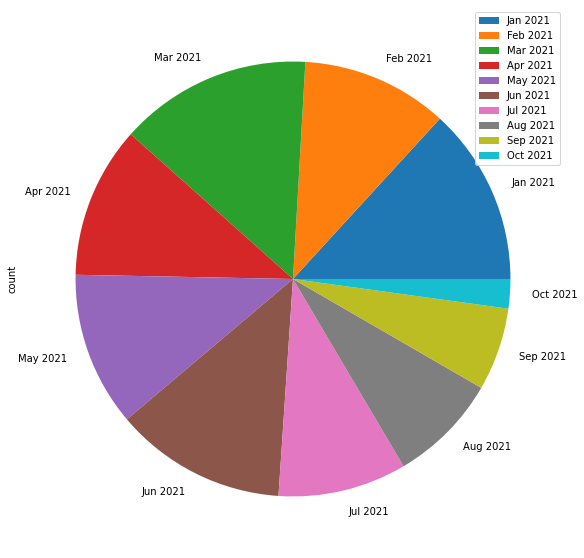

In [0]:
df.plot(kind = 'pie', y='count', figsize=(10, 10))